In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

# ****Function for detecting Horizontal and Vertical edges in a image****

### Kernel_1 is for detecting the vertical edges and kernel_2 is for detecting the horizontal edges and this detection makes the image more clear for detecting the power lines

In [2]:
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

kernel_1 = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])
kernel_2 = np.array([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]])
def edge(im):
    out1 = convolve2d(im, kernel_1)
    out2 = convolve2d(im, kernel_2)
    new=np.sqrt(np.square(out1)+np.square(out2))
    return new

def make(im):
    im= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
    a=edge(im)
    a=a[:128,:128]
    im1=im.reshape(128,128,1)
    im2=a.reshape(128,128,1)
    return np.concatenate((im1,im2), axis=2)

# ****Loading the training Dataset****

In [3]:
import cv2 
import os 
import glob 
img_dir = "/kaggle/input/recognizance-2/Data/train/Powerline" # Enter Directory of all images  
data_path = os.path.join(img_dir,'*.bmp') 
files = glob.glob(data_path) 
train = [] 
train_labels=[]
images=[]
for f1 in files: 
    img = cv2.imread(f1) 
    images.append(img)
    train.append(make(img))
    train_labels.append(1)

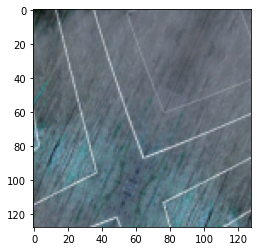

In [4]:
plt.imshow(images[0])

In [5]:
img_dir = "/kaggle/input/recognizance-2/Data/train/No_powerline" # Enter Directory of all images  
data_path = os.path.join(img_dir,'*.bmp') 
files = glob.glob(data_path) 
for f1 in files: 
    img = cv2.imread(f1)
    images.append(img)
    train.append(make(img))
    train_labels.append(0)

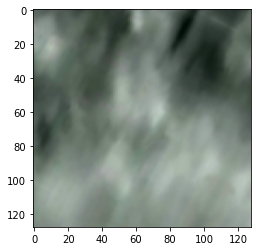

In [6]:
plt.imshow(images[len(images)-1])

# ****Shuffling the training images and labels****

In [7]:
import random
temp=list(zip(train,train_labels))
for i in range(100):
    random.shuffle(temp)
train,train_labels=zip(*temp)
train=np.array(train)
train_labels=np.array(train_labels)

In [8]:
train[0].shape

(128, 128, 2)

In [9]:
train=np.array(train)
train_labels=np.array(train_labels)

In [10]:
train.shape

(10000, 128, 128, 2)

# ****Importing the necessary Libraries****

In [11]:
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

# ****Initializing our Model****

In [12]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,2)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))



model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

# ****Model Prototype****

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      816       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0

In [14]:
optimizer =  RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 100

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(train, train_labels, test_size = 0.1, random_state= 2)
X_train=X_train/255.0
X_val=X_val/255.0

In [17]:
X_train=train/255.0
Y_train=train_labels

# ****Training our model****

In [18]:
history = model.fit( X_train,Y_train, batch_size=batch_size,
                              epochs = 30, 
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                               )

Epoch 1/30
100/100 [==============================] - 10s 55ms/step - loss: 0.6981 - accuracy: 0.5248
Epoch 2/30
100/100 [==============================] - 5s 55ms/step - loss: 0.6975 - accuracy: 0.5906
Epoch 3/30
100/100 [==============================] - 6s 55ms/step - loss: 0.5627 - accuracy: 0.7001
Epoch 4/30
100/100 [==============================] - 5s 55ms/step - loss: 0.4129 - accuracy: 0.8048
Epoch 5/30
100/100 [==============================] - 6s 55ms/step - loss: 0.3628 - accuracy: 0.8435
Epoch 6/30
100/100 [==============================] - 6s 56ms/step - loss: 0.3238 - accuracy: 0.8657
Epoch 7/30
100/100 [==============================] - 5s 54ms/step - loss: 0.2969 - accuracy: 0.8779
Epoch 8/30
100/100 [==============================] - 5s 54ms/step - loss: 0.2615 - accuracy: 0.9033
Epoch 9/30
100/100 [==============================] - 6s 55ms/step - loss: 0.2660 - accuracy: 0.8952
Epoch 10/30
100/100 [==============================] - 6s 55ms/step - loss: 0.2431 - accur

In [19]:
del train

In [20]:
del train_labels

# ****Loading the test Dataset****

In [21]:
img_dir = "/kaggle/input/recognizance-2/Data/test" # Enter Directory of all images  
data_path = os.path.join(img_dir,'*.bmp') 
files = glob.glob(data_path) 
test_images = []
for f1 in files: 
    img = cv2.imread(f1) 
    test_images.append(make(img)) 

In [22]:
del X_train

In [23]:
test_images=np.array(test_images)

In [24]:
test_images=test_images/255.0

In [25]:
test_images.shape

(6078, 128, 128, 2)

# ****Predicting the test images****

In [26]:
test_labels=model.predict(test_images)

In [27]:
labels=[]
for i in test_labels:
    if(i>0.5):
        labels.append("YES")
    else:
        labels.append("NO")

In [28]:
test_names=[]
for f1 in files:  
    test_names.append(f1)

In [29]:
for i in range(0,len(test_images)):
    test_names[i]=test_names[i][39:]
test_names[0] 

'Check   (3311).bmp'

In [30]:
file=pd.DataFrame(test_names,columns=['image file name'])
file['Powerline']=labels
file

,image file name,Powerline
0,Check (3311).bmp,NO
1,Check (2007).bmp,YES
2,Check (118).bmp,YES
3,Check (340).bmp,NO
4,Check (2374).bmp,YES
...,...,...
6073,Check (633).bmp,NO
6074,Check (1595).bmp,NO
6075,Check (2571).bmp,NO
6076,Check (2029).bmp,YES


# ****Saving the file for submission****

In [31]:
file.to_csv('output.csv',index=False)